__File: srg_operator_evolution_figures.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     May 17, 2019__

This notebook creates several SRG operator evolution figures. Each function creates and saves a figure to the __Figures/SRG_operator_evolution__ folder. Below is an outline of each function:
* deuteron_momentum_distribution - Plots a semi-log figure of deuteron momentum distributions comparing initial and SRG-evolved $\psi^2$. Note this depicts $\psi(s)^2$ not $\psi^{\dagger}(0) U^{\dagger}(s) U(s) \psi(0)$ which is the same as the initial momentum distribution.
* continuum_state_distribution - Analog of the deuteron_momentum_distribution function but for some state $\epsilon_k$ > 0 MeV.
* potential_contours - Plots contours of an SRG-evolving potential in $\lambda$.
* momentum_projection_contours - Plots contours of the momentum projection operator SRG-evolving in $\lambda$.
* momentum_projection_integrand - Plots contours of the integrand of the inner product of the momentum projection operator with the deuteron wave function SRG-evolving in $\lambda$. Work in progress.
* r2_contours - Plots contours of the radius squared operator SRG-evolving in $\lambda$. Work in progress.

__Revision history:<br/>__
* May 29, 2019 - Updated with changes to _deuteron.py_, _operators.py_, and _observables.py_.
* June 3, 2019 - Added a function for generating evolved potentials, potential_contours.
* August 7, 2019 - Updated r^2 function (still incomplete - update this bullet once it's finalized).

In [1]:
from os import chdir, getcwd
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.linalg import expm
# Scripts made by A.T.
from Figures import figures_functions as ff
from Potentials.vsrg_macos import load_save_potentials as lp
import observables as ob
import operators as op
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

__Momentum distributions__

* Plotting functions for comparing initial and evolved momentum distributions.

In [2]:
def deuteron_momentum_distribution(kvnn, kmax, kmid, ntot, generator, lamb, lambda_bd=0.00):
    """
    Plots a semi-log figure of the deuteron momentum distribution |psi_d(k)|^2 [fm^3] as a function of momentum k 
    [fm^-1] with psi_d(0) from the bare Hamiltonian and psi_d(lambda) from an evolved Hamiltonian at a given 
    value of lambda. Must specify details of the SRG-evolved potential, hence the arguments kvnn, channel, etc.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda in units fm^-1.
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1).

    Saves
    -----
    file_name = deuteron_momentum_distribution_ with an extension based off the given arguments.
    file_type = .pdf
    
    """
    
    cwd = getcwd()
    
    # Load momentum distributions
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    # Deuteron energy in MeV
    eps = -2.22
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Load unitary transformation
    # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
    # Compute initial and evolved wave functions
    psi_initial = ob.wave_function(H_initial, eps)
    u_initial = psi_initial[:ntot] # 3S1 component
    w_initial = psi_initial[ntot:] # 3D1 component
    
    psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
    u_evolved = psi_evolved[:ntot] # 3S1 component
    w_evolved = psi_evolved[ntot:] # 3D1 component
    
    # Initial and evolved momentum distribution (divide by momenta and weights for mesh-independent result)
    phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
    phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
    
    
    # Plot specifications

    # Limits of x and y axes
    xlim = [0.0, 4.0]
    ylim = [1e-5, 1e3]
    
    # Labels
    k_label = r'$k \/ [fm^{-1}]$'
    phi_squared_label = r'$\phi_d^2 \/ \/ [fm^3]$'
    lamb_label = r'$\lambda=%.1f \/ \/ fm^{-1}$'
    if generator == 'Block-diag':
        generator_label = r'$G=H_{BD}$'+'\n'+r'$\Lambda=%.2f \/ fm^{-1}$'%lambda_bd
    elif generator == 'Wegner':
        generator_label = r'$G=H_{D}$'
    elif generator == 'T':
        generator_label = r'$G=T_{rel}$'
    
    # Fontsize for labels
    legend_label_size = 16
    k_label_size = 18
    phi_squared_label_size = 20
    generator_label_size = 20
    
    # Location of labels
    legend_label_location = 1
    generator_label_location = 3
    
    
    # Plot the semi-log figure
    plt.close('all')
    
    f, ax = plt.subplots()
    
    ax.semilogy(k_array, phi_squared_evolved, 'r-', label=lamb_label%lamb)
    ax.semilogy(k_array, phi_squared_initial, 'k:', label=r'$\lambda=\infty \/ \/ fm^{-1}$')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    ax.set_xlabel(k_label, fontsize=k_label_size)
    ax.set_ylabel(phi_squared_label, fontsize=phi_squared_label_size)
    anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size),
                                 loc=generator_label_location, frameon=False)
    ax.add_artist(anchored_text)
    
    
    # Save figure as a .pdf
    
    # Name of the file
    if generator == 'Block-diag':
        name = 'deuteron_momentum_distribution_kvnn%d_%s%.2f_lamb%.1f'%(kvnn, generator, lambda_bd, lamb)
    else:
        name = 'deuteron_momentum_distribution_kvnn%d_%s_lamb%.1f'%(kvnn, generator, lamb)
        
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(name)
    
    chdir('Figures/SRG_operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [3]:
def continuum_state_momentum_distribution(eps, kvnn, kmax, kmid, ntot, generator, lamb, lambda_bd=0.00):
    """
    Plots a semi-log figure of the momentum distribution |psi_eps(k)|^2 [fm^3] as a function of momentum k 
    [fm^-1] with psi_eps(0) from the bare Hamiltonian and psi_eps(lambda) from an evolved Hamiltonian at a given 
    value of lambda. Epsilon specifies the energy of the state (i.e. epsilon = -2.22 MeV would corrspond to 
    deuteron). Must specify details of the SRG-evolved potential, hence the arguments kvnn, channel, etc.
    
    Parameters
    ----------
    eps : float
        Energy value in units MeV.
    kvnn : int
        This number specifies the potential.
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda in units fm^-1.
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1).

    Saves
    -----
    file_name = continuum_state_momentum_distribution_ with an extension based off the given arguments.
    file_type = .pdf
    
    """
    
    cwd = getcwd()
    
    # Load momentum distributions
    
    # Channel is 3S1
    channel = '3S1'
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Load unitary transformation
    # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
    # Compute initial and evolved wave functions
    psi_initial = ob.wave_function(H_initial, eps)
    u_initial = psi_initial[:ntot] # 3S1 component
    w_initial = psi_initial[ntot:] # 3D1 component
    
    psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
    u_evolved = psi_evolved[:ntot] # 3S1 component
    w_evolved = psi_evolved[ntot:] # 3D1 component
    
    # Initial and evolved momentum distribution (divide by momenta and weights for mesh-independent result)
    phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
    phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
    
    
    # Plot specifications

    # Limits of x and y axes
    xlim = [0.0, 4.0]
    ylim = [1e-6, 1e2]
    
    # Labels
    k_label = r'$k \/ [fm^{-1}]$'
    phi_squared_label = r'$\phi_{\epsilon}^2 \/ \/ [fm^3]$'
    lamb_label = r'$\lambda=%.1f \/ \/ fm^{-1}$'
    if generator == 'Block-diag':
        generator_label = r'$G=H_{BD}$'+'\n'+r'$\Lambda=%.2f \/ fm^{-1}$'%lambda_bd
    elif generator == 'Wegner':
        generator_label = r'$G=H_{D}$'
    elif generator == 'T':
        generator_label = r'$G=T_{rel}$'
    # This label can be written explicitly in the caption of the figure
    #eps_label = r'$\epsilon \approx %.1f \/ \/ MeV$'%eps
    
    # Fontsize for labels
    legend_label_size = 16
    k_label_size = 18
    phi_squared_label_size = 20
    generator_label_size = 18
    #eps_label_size = 18
    
    # Location of labels
    legend_label_location = 2
    #if generator == 'Block-diag':
        #if kvnn == 10:
            #generator_label_location = 3
        #else:
            #generator_label_location = 6
    #else:
        #generator_label_location = 7
    #eps_label_location = 1
    generator_label_location = 1
    
    
    # Plot the semi-log figure
    plt.close('all')
    
    f, ax = plt.subplots()
    
    ax.semilogy(k_array, phi_squared_evolved, 'r-', label=lamb_label%lamb)
    ax.semilogy(k_array, phi_squared_initial, 'k:', label=r'$\lambda=\infty \/ \/ fm^{-1}$')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    ax.set_xlabel(k_label, fontsize=k_label_size)
    ax.set_ylabel(phi_squared_label, fontsize=phi_squared_label_size)
    anchored_text_1 = AnchoredText(generator_label, prop=dict(size=generator_label_size),
                                   loc=generator_label_location, frameon=False)
    ax.add_artist(anchored_text_1)
    #anchored_text_2 = AnchoredText(eps_label, prop=dict(size=eps_label_size), loc=eps_label_location, frameon=False)
    #ax.add_artist(anchored_text_2)
    
    
    # Save figure as a .pdf
    
    # Name of the file
    if generator == 'Block-diag':
        name = 'continuum_state_momentum_distribution_eps%.1f_kvnn%d_%s%.2f_lamb%.1f'%(eps, kvnn, generator, 
                                                                                       lambda_bd, lamb)
    else:
        name = 'continuum_state_momentum_distribution_eps%.1f_kvnn%d_%s_lamb%.1f'%(eps, kvnn, generator, lamb)
        
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(name)
        
    chdir('Figures/SRG_operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

__Operator evolution__

* Plotting functions for operator evolution evolving in $\lambda$.

In [4]:
def potential_contours(kvnn, channel, kmax, kmid, ntot, generator, lambda_bd=0.00):
    """
    Plots a 1 x 4 sub-plots figure of an NN potential evolving from lambda = 6.0 to 1.5 fm^-1 as contour plots. Must
    specify details of the SRG-evolved potential, hence the arguments kvnn, channel, etc.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1).

    Saves
    -----
    file_name = potential_contours_ with an extension based off the given arguments.
    file_type = .pdf
    
    """
    
    # Current working directory
    cwd = getcwd()
    
    # Limits of axes on contours (units are fm^-1)
    axes_max = 4.0
    
    # Store evolved potentials
    
    # Load momentum for interpolation
    k_array = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)[0]
    
    # Loop over lambda values in lambdas and save evolved potentials to dictionary where the keys are lambda values
    lambdas = [6.0, 3.0, 2.0, 1.5]
    
    # Initialize dictionary
    d = {}
    
    for lamb in lambdas:
        
        # Load evolved potential
        V_evolved = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
        
        # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
        # interpolated)
        k_array_int, V_evolved_int = ff.interpolate_matrix(k_array, V_evolved, axes_max)
        
        # Save potential to dictionary
        d[lamb] = V_evolved_int
    
    
    # Plot specifications
    
    # Labels
    k_label = r'$k \/ \/ [fm^{-1}]$'
    if generator == 'Block-diag':
        generator_label = r'$G=H_{BD}$'+'\n'+r'$\Lambda=%.2f \/ fm^{-1}$'%lambda_bd
    elif generator == 'Wegner':
        generator_label = r'$G=H_{D}$'
    elif generator == 'T':
        generator_label = r'$G=T_{rel}$'
    lamb_label = r'$\lambda=%.1f \/ fm^{-1}$'
    colorbar_label = r'$[fm]$'
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    generator_label_size = 17
    lambda_label_size = 17
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
    
        
    # Location of labels
    generator_location = 1
    lamb_location = 3
        
    # Color scheme for contour plots
    color_style = 'jet'
    
    # Limits of color bar in fm and colorbar step-size
    mx = 1.0
    mn = -1.0
    color_bar_stepsize = 0.5
        
    # Colorbar ticks and labels (the value of the ticks are floats and the labels are strings)
    colorbar_ticks = np.arange(mn, mx + color_bar_stepsize, color_bar_stepsize)
    colorbar_ticks_list = []
    for tick in colorbar_ticks:
        colorbar_ticks_list.append(str(tick))
        
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    
    
    # Plot the 1 x 4 sub-plots figure     
    plt.close('all')
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16,3.5))
    
    # Sub-plot 1: lambda = 6.0 fm^-1
    ax1.pcolormesh(k_array_int, k_array_int, d[ lambdas[0] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax1.set_xlim( (0, axes_max) )
    ax1.set_ylim( (0, axes_max) )
    # Set x and y labels
    ax1.set_xlabel(k_label, fontsize=axes_label_size)
    ax1.set_ylabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax1.xaxis.set_ticks(axes_ticks)
    ax1.xaxis.set_ticklabels(axes_ticks)
    ax1.yaxis.set_ticks(axes_ticks)
    ax1.yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = ax1.xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    # Add lambda label onto plot as anchored text
    anchored_text_1 = AnchoredText(lamb_label%lambdas[0], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax1.add_artist(anchored_text_1)
    
    # Sub-plot 2: lambda = 3.0 fm^-1
    ax2.pcolormesh(k_array_int, k_array_int, d[ lambdas[1] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax2.set_xlim( (0, axes_max) )
    ax2.set_ylim( (0, axes_max) )
    # Set x label
    ax2.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax2.xaxis.set_ticks(axes_ticks)
    ax2.xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    ax2.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_2 = ax2.xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Add lambda label onto plot as anchored text
    anchored_text_2 = AnchoredText(lamb_label%lambdas[1], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax2.add_artist(anchored_text_2)
    
    # Sub-plot 3: lambda = 2.0 fm^-1
    ax3.pcolormesh(k_array_int, k_array_int, d[ lambdas[2] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax3.set_xlim( (0, axes_max) )
    ax3.set_ylim( (0, axes_max) )
    # Set x label
    ax3.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax3.xaxis.set_ticks(axes_ticks)
    ax3.xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    ax3.xaxis.set_label_position('top')
    ax3.xaxis.tick_top()
    ax3.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_3 = ax3.xaxis.get_major_ticks()
    xticks_3[-1].set_visible(False)
    # Add generator and lambda labels onto plot as anchored texts
    anchored_text_3 = AnchoredText(lamb_label%lambdas[2], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax3.add_artist(anchored_text_3)
    anchored_text_4 = AnchoredText(generator_label, prop=dict(size=generator_label_size), loc=generator_location)
    ax3.add_artist(anchored_text_4)

    # Sub-plot 4: lambda = 1.5 fm^-1
    c = ax4.pcolormesh(k_array_int, k_array_int, d[ lambdas[3] ], cmap=color_style, vmin=mn, vmax=mx, 
                       rasterized=True)
    # Set limits of axes
    ax4.set_xlim( (0, axes_max) )
    ax4.set_ylim( (0, axes_max) )
    # Set x label
    ax4.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax4.xaxis.set_ticks(axes_ticks)
    ax4.xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis label and tick marks
    ax4.xaxis.set_label_position('top')
    ax4.xaxis.tick_top()
    ax4.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Add lambda label onto plot as anchored text
    anchored_text_5 = AnchoredText(lamb_label%lambdas[3], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax4.add_artist(anchored_text_5)

    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    # Add colorbar and set ticks
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.set_ticks(colorbar_ticks)
    cbar.set_ticklabels(colorbar_ticks_list)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar label
    cbar.set_label(colorbar_label, rotation=0, labelpad=18, fontsize=colorbar_label_size)

    
    # Save figure as a .pdf
    
    # Name of the file
    if generator == 'Block-diag':
        name = 'potential_contours_kvnn%d_%s_%s%.2f'%(kvnn, channel, generator, lambda_bd)
        # Replace '.' with ',' in file name since LaTeX doesn't like periods
        file_name = ff.replace_periods_with_commas(name)
    else:
        file_name = 'potential_contours_kvnn%d_%s_%s'%(kvnn, channel, generator)
        
    chdir('Figures/SRG_operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [5]:
def momentum_projection_contours(q, kvnn, channel, kmax, kmid, ntot, generator, lambda_bd=0.00):
    """
    Plots a 1 x 4 sub-plots figure of the momentum projection operator evolving from lambda = 6.0 to 1.5 fm^-1 as 
    contour plots. Must specify details of the SRG-evolved potential, hence the arguments kvnn, channel, etc.
    
    Parameters
    ----------
    q : float
        Momentum value in units fm^-1.
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1).

    Saves
    -----
    file_name = momentum_projection_contours_ with an extension based off the given arguments.
    file_type = .pdf
    
    """
    
    # Current working directory
    cwd = getcwd()
    
    # Limits of axes on contours (units are fm^-1)
    axes_max = 4.0
    
    # Store evolved operators
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    # The arrays below are used later to present a mesh-independent result 
    row, col = np.meshgrid(k_array*np.sqrt(k_weights), k_array*np.sqrt(k_weights))
    #row, col = np.meshgrid(2/np.pi * k_array**2 * k_weights, 2/np.pi * k_array**2 * k_weights)
    
    # Loop over lambda values in lambdas and save evolved operators to dictionary where the keys are lambda values
    lambdas = [6.0, 3.0, 2.0, 1.5]
    
    # Initialize dictionary
    d = {}
    
    for lamb in lambdas:
        
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Evolved momentum projection operator in 3S1 channel divided by k_i * k_j * sqrt( w_i * w_j ) for 
        # mesh-independent result
        operator = op.momentum_projection_operator(q, k_array, k_weights, U_matrix)[:ntot, :ntot] / row / col
        #operator = op.momentum_projection_operator(q, k_array, k_weights, U_matrix)[:ntot, :ntot]
        
        # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
        # interpolated)
        k_array_int, operator_int = ff.interpolate_matrix(k_array, operator, axes_max)
        #k_array_int = k_array
        #operator_int = operator
        #if lamb == 1.5:
            #print('kmax = %d fm^-1'%kmax)
            #print(operator[:10,:10])
        
        # Save operator to dictionary
        d[lamb] = operator_int
    
    
    # Plot specifications
    
    # Labels
    k_label = r'$k \/ \/ [fm^{-1}]$'
    #q_label = r'$q=%.2f \/ fm^{-1}$'%q # This label can be written explicitly in the caption of the figure
    if generator == 'Block-diag':
        generator_label = r'$G=H_{BD}$'+'\n'+r'$\Lambda=%.2f \/ fm^{-1}$'%lambda_bd
    elif generator == 'Wegner':
        generator_label = r'$G=H_{D}$'
    elif generator == 'T':
        generator_label = r'$G=T_{rel}$'
    lamb_label = r'$\lambda=%.1f \/ fm^{-1}$'
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    #q_label_size = 18
    generator_label_size = 17
    lambda_label_size = 17
    axes_tick_size = 18
    colorbar_tick_size = 18
        
    # Location of labels (dependent on specified q value)
    if q < axes_max/2:
        #q_location = 7
        generator_location = 7
        lamb_location = 4
    else:
        #q_location = 2
        generator_location = 2
        lamb_location = 3
        
    # Color scheme for contour plots
    color_style = 'jet'
    
    # Limits of color bar in fm and colorbar step-size (dependent on specified q value)
    if q < axes_max/2:
        mx = 1.0
        mn = -1.0
    else:
        mx = 0.01
        #mx = 1e-3
        #mx = 0.1
        mn = -0.01
        #mn = -1e-3
        #mn = -0.1
        
    # Step-size in colorbar ticks
    color_bar_stepsize = 0.5*mx
        
    # Colorbar ticks and labels (the value of the ticks are floats and the labels are strings)
    colorbar_ticks = np.arange(mn, mx + color_bar_stepsize, color_bar_stepsize)
    colorbar_ticks_list = []
    for tick in colorbar_ticks:
        if mx == 0.01:
            tick_str = '%.3f'%tick
        elif mx == 1e-3:
            tick_str = '%.1e'%tick
        colorbar_ticks_list.append(tick_str)
        
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    
    
    # Plot the 1 x 4 sub-plots figure     
    plt.close('all')
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16,3.5))
    
    # Sub-plot 1: lambda = 6.0 fm^-1
    ax1.pcolormesh(k_array_int, k_array_int, d[ lambdas[0] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax1.set_xlim( (0, axes_max) )
    ax1.set_ylim( (0, axes_max) )
    # Set x and y labels
    ax1.set_xlabel(k_label, fontsize=axes_label_size)
    ax1.set_ylabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax1.xaxis.set_ticks(axes_ticks)
    ax1.xaxis.set_ticklabels(axes_ticks)
    ax1.yaxis.set_ticks(axes_ticks)
    ax1.yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis labels and tick marks
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = ax1.xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    # Add generator and lambda labels onto plot as anchored texts
    anchored_text_1 = AnchoredText(generator_label, prop=dict(size=generator_label_size), loc=generator_location)
    ax1.add_artist(anchored_text_1)
    anchored_text_2 = AnchoredText(lamb_label%lambdas[0], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax1.add_artist(anchored_text_2)
    
    # Sub-plot 2: lambda = 3.0 fm^-1
    ax2.pcolormesh(k_array_int, k_array_int, d[ lambdas[1] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax2.set_xlim( (0, axes_max) )
    ax2.set_ylim( (0, axes_max) )
    # Set x label
    ax2.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax2.xaxis.set_ticks(axes_ticks)
    ax2.xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis labels and tick marks
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    ax2.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_2 = ax2.xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Add lambda label onto plot as anchored text
    anchored_text_3 = AnchoredText(lamb_label%lambdas[1], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax2.add_artist(anchored_text_3)
    
    # Sub-plot 3: lambda = 2.0 fm^-1
    ax3.pcolormesh(k_array_int, k_array_int, d[ lambdas[2] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax3.set_xlim( (0, axes_max) )
    ax3.set_ylim( (0, axes_max) )
    # Set x label
    ax3.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax3.xaxis.set_ticks(axes_ticks)
    ax3.xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis labels and tick marks
    ax3.xaxis.set_label_position('top')
    ax3.xaxis.tick_top()
    ax3.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_3 = ax3.xaxis.get_major_ticks()
    xticks_3[-1].set_visible(False)
    # Add lambda label onto plot as anchored text
    anchored_text_4 = AnchoredText(lamb_label%lambdas[2], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax3.add_artist(anchored_text_4)

    # Sub-plot 4: lambda = 1.5 fm^-1
    c = ax4.pcolormesh(k_array_int, k_array_int, d[ lambdas[3] ], cmap=color_style, vmin=mn, vmax=mx, 
                       rasterized=True)
    # Set limits of axes
    ax4.set_xlim( (0, axes_max) )
    ax4.set_ylim( (0, axes_max) )
    # Set x label
    ax4.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax4.xaxis.set_ticks(axes_ticks)
    ax4.xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis labels and tick marks
    ax4.xaxis.set_label_position('top')
    ax4.xaxis.tick_top()
    ax4.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Add lambda label onto plot as anchored text
    anchored_text_5 = AnchoredText(lamb_label%lambdas[3], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax4.add_artist(anchored_text_5)

    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    # Add colorbar and set ticks
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.set_ticks(colorbar_ticks)
    cbar.set_ticklabels(colorbar_ticks_list)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)

    
    # Save figure as a .pdf
    
    # Name of the file
    if generator == 'Block-diag':
        name = 'momentum_projection_contours_q%.2f_kvnn%d_%s_%s%.2f'%(q, kvnn, channel, generator, lambda_bd)
    else:
        name = 'momentum_projection_contours_q%.2f_kvnn%d_%s_%s'%(q, kvnn, channel, generator)
        
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(name)
        
    chdir('Figures/SRG_operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)
    
    # Testing purposes!
    plt.show()

In [6]:
# Work in progress
def r2_contours(kvnn, channel, kmax, kmid, ntot, generator, lambda_bd=0.00):
    """
    Plots a 1 x 4 sub-plots figure of the r^2 operator in momentum-space evolving from lambda = 6.0 to 1.5 fm^-1 as
    contour plots. Must specify details of the SRG-evolved potential, hence the arguments kvnn, channel, etc.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1).

    Saves
    -----
    file_name = r2_contours_ with an extension based off the given arguments.
    file_type = .pdf
    
    """
    # Current working directory
    cwd = getcwd()
    
    # Limits of axes on contours (units are fm^-1)
    axes_max = 0.4
    
    # Store evolved operators
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    # The arrays below are used later to present a mesh-independent result 
    row, col = np.meshgrid(k_array*np.sqrt(k_weights), k_array*np.sqrt(k_weights))
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Loop over lambda values in lambdas and save evolved operators to dictionary where the keys are lambda values
    lambdas = [6.0, 3.0, 2.0, 1.5]
    
    # Initialize dictionary
    d = {}
    
    for lamb in lambdas:
        
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Evolved r^2 operator in 3S1 channel divided by k_i * k_j * sqrt( w_i * w_j ) for 
        # mesh-independent result
        operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)[:ntot, :ntot]
        #operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)[:ntot, :ntot] / row / col
        
        # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
        # interpolated)
        k_array_int, operator_int = ff.interpolate_matrix(k_array, operator, axes_max)
        
        # Save operator to dictionary
        d[lamb] = operator_int
        
        
    # Plot specifications
    
    # Labels
    k_label = r'$k \/ \/ [fm^{-1}]$'
    if generator == 'Block-diag':
        generator_label = r'$G=H_{BD}$'+'\n'+r'$\Lambda=%.2f \/ fm^{-1}$'%lambda_bd
    elif generator == 'Wegner':
        generator_label = r'$G=H_{D}$'
    elif generator == 'T':
        generator_label = r'$G=T_{rel}$'
    lamb_label = r'$\lambda=%.1f \/ fm^{-1}$'
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    generator_label_size = 17
    lambda_label_size = 17
    axes_tick_size = 18
    colorbar_tick_size = 18
        
    # Location of labels
    generator_location = 1
    lamb_location = 3
        
    # Color scheme for contour plots
    color_style = 'jet'
    
    # Limits of color bar in fm and colorbar step-size
    mx = 1e6
    mn = -1e6
        
    # Step-size in colorbar ticks
    color_bar_stepsize = 0.5*mx
        
    # Colorbar ticks and labels (the value of the ticks are floats and the labels are strings)
    colorbar_ticks = np.arange(mn, mx + color_bar_stepsize, color_bar_stepsize)
    colorbar_ticks_list = []
    for tick in colorbar_ticks:
        colorbar_ticks_list.append(str(tick))
        
    # Step-size in labeling tick marks
    axes_stepsize = 0.1
    
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_list = []
    for tick in axes_ticks:
        axes_ticks_list.append('%.1f'%tick)
    
    
    # Plot the 1 x 4 sub-plots figure     
    plt.close('all')
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16,3.5))
    
    # Sub-plot 1: lambda = 6.0 fm^-1
    ax1.pcolormesh(k_array_int, k_array_int, d[ lambdas[0] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax1.set_xlim( (0, axes_max) )
    ax1.set_ylim( (0, axes_max) )
    # Set x and y labels
    ax1.set_xlabel(k_label, fontsize=axes_label_size)
    ax1.set_ylabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax1.xaxis.set_ticks(axes_ticks)
    ax1.xaxis.set_ticklabels(axes_ticks_list)
    ax1.yaxis.set_ticks(axes_ticks)
    ax1.yaxis.set_ticklabels(axes_ticks_list)
    # Position of x-axis labels and tick marks
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = ax1.xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    # Add generator and lambda labels onto plot as anchored texts
    anchored_text_1 = AnchoredText(generator_label, prop=dict(size=generator_label_size), loc=generator_location)
    ax1.add_artist(anchored_text_1)
    anchored_text_2 = AnchoredText(lamb_label%lambdas[0], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax1.add_artist(anchored_text_2)
    
    # Sub-plot 2: lambda = 3.0 fm^-1
    ax2.pcolormesh(k_array_int, k_array_int, d[ lambdas[1] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax2.set_xlim( (0, axes_max) )
    ax2.set_ylim( (0, axes_max) )
    # Set x label
    ax2.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax2.xaxis.set_ticks(axes_ticks)
    ax2.xaxis.set_ticklabels(axes_ticks_list)
    # Position of x-axis labels and tick marks
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    ax2.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_2 = ax2.xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Add lambda label onto plot as anchored text
    anchored_text_3 = AnchoredText(lamb_label%lambdas[1], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax2.add_artist(anchored_text_3)
    
    # Sub-plot 3: lambda = 2.0 fm^-1
    ax3.pcolormesh(k_array_int, k_array_int, d[ lambdas[2] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax3.set_xlim( (0, axes_max) )
    ax3.set_ylim( (0, axes_max) )
    # Set x label
    ax3.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax3.xaxis.set_ticks(axes_ticks)
    ax3.xaxis.set_ticklabels(axes_ticks_list)
    # Position of x-axis labels and tick marks
    ax3.xaxis.set_label_position('top')
    ax3.xaxis.tick_top()
    ax3.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_3 = ax3.xaxis.get_major_ticks()
    xticks_3[-1].set_visible(False)
    # Add lambda label onto plot as anchored text
    anchored_text_4 = AnchoredText(lamb_label%lambdas[2], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax3.add_artist(anchored_text_4)

    # Sub-plot 4: lambda = 1.5 fm^-1
    c = ax4.pcolormesh(k_array_int, k_array_int, d[ lambdas[3] ], cmap=color_style, vmin=mn, vmax=mx, 
                       rasterized=True)
    # Set limits of axes
    ax4.set_xlim( (0, axes_max) )
    ax4.set_ylim( (0, axes_max) )
    # Set x label
    ax4.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax4.xaxis.set_ticks(axes_ticks)
    ax4.xaxis.set_ticklabels(axes_ticks_list)
    # Position of x-axis labels and tick marks
    ax4.xaxis.set_label_position('top')
    ax4.xaxis.tick_top()
    ax4.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Add lambda label onto plot as anchored text
    anchored_text_5 = AnchoredText(lamb_label%lambdas[3], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax4.add_artist(anchored_text_5)

    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    # Add colorbar and set ticks
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.set_ticks(colorbar_ticks)
    cbar.set_ticklabels(colorbar_ticks_list)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)

    
    # Save figure as a .pdf
    
    # Name of the file
    if generator == 'Block-diag':
        name = 'r2_contours_kvnn%d_%s_%s%.2f'%(kvnn, channel, generator, lambda_bd)
    else:
        name = 'r2_contours_kvnn%d_%s_%s'%(kvnn, channel, generator)
        
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(name)
        
    chdir('Figures/SRG_operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

__Integrand evolution__

* Plotting functions for integrand evolution evolving in $\lambda$ where the integrands correspond to the inner product of some operator $O$ and wave function $\psi$.

In [7]:
# Work in progress: Plots seem to be off by a factor involving momenta and weights
def momentum_projection_integrand(q, kvnn, channel, kmax, kmid, ntot, generator, lambda_bd=0.00):
    """
    Plots a 1 x 4 sub-plots figure of the integrand of an SRG-evolved momentum projection operator sandwiched with
    a consistently evolved wave function evolving from lambda = 6.0 to 1.5 fm^-1 as contour plots. Must specify 
    details of the SRG-evolved potential, hence the arguments kvnn, channel, etc.
    
    Parameters
    ----------
    q : float
        Momentum value in units fm^-1.
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1).

    Saves
    -----
    file_name = momentum_projection_integrand_ with an extension based off the given arguments.
    file_type = .pdf
    
    """
    
    # Current working directory
    cwd = getcwd()
    
    # Limits of axes on contours (units are fm^-1)
    axes_max = 4.0
    
    # Store evolved integrands
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    k_array_double = np.concatenate( (k_array, k_array) )
    k_weights_double = np.concatenate( (k_weights, k_weights) )
    # The arrays below are used later to present a mesh-independent result 
    row, col = np.meshgrid(k_array*np.sqrt(k_weights), k_array*np.sqrt(k_weights))
    row_double, col_double = np.meshgrid(k_array_double*np.sqrt(k_weights_double), 
                                         k_array_double*np.sqrt(k_weights_double))
    
    # Loop over lambda values in lambdas and save evolved operators to dictionary where the keys are lambda values
    lambdas = [6.0, 3.0, 2.0, 1.5]
    
    # Initialize dictionary
    d = {}
    
    for lamb in lambdas:
        
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Evolved momentum projection operator in 3S1 channel divided by k_i * k_j * sqrt( w_i * w_j ) for 
        # mesh-independent result
        operator = op.momentum_projection_operator(q, k_array, k_weights, U_matrix)
        #operator = op.momentum_projection_operator(q, k_array, k_weights, U_matrix) / row_double / col_double
        
        # Load evolved wave functions and divide out momentum and weights
        psi = ob.wave_function(H_initial, eps=-2.22, U=U_matrix)
        #psi = ob.wave_function(H_evolved, eps=-2.22) # This is the same as the line above
        #psi = ob.wave_function(H_initial, eps=-2.22, U=U_matrix) / ( k_array_double * np.sqrt(k_weights_double) )
        # Mesh-grids of psi
        psi_row, psi_col = np.meshgrid(psi, psi)
        
        # Integrand of < psi | a^dagger_q a_q | psi >
        integrand = psi_row * operator * psi_col
        
        # Re-size to S-S block
        integrand = integrand[:ntot, :ntot] * 2 / np.pi
        #integrand = integrand[:ntot, :ntot] / row / col * 2 / np.pi
        #integrand = integrand[:ntot, :ntot] / row / col
        #integrand = integrand[:ntot, :ntot] / row**2 / col**2
        # For log plot take absolute value
        #integrand = abs(integrand)
        
        # Interpolate the integrand through 0 to axes_max for smoother looking figure (the extension _int means 
        # interpolated)
        k_array_int, integrand_int = ff.interpolate_matrix(k_array, integrand, axes_max)
        #k_array_int = k_array
        #integrand_int = integrand
        
        # Save integrand to dictionary
        d[lamb] = integrand_int
    
    
    # Plot specifications
    
    # Labels
    k_label = r'$k \/ \/ [fm^{-1}]$'
    #q_label = r'$q=%.2f \/ fm^{-1}$'%q # This label can be written explicitly in the caption of the figure
    if generator == 'Block-diag':
        generator_label = r'$G=H_{BD}$'+'\n'+r'$\Lambda=%.2f \/ fm^{-1}$'%lambda_bd
    elif generator == 'Wegner':
        generator_label = r'$G=H_{D}$'
    elif generator == 'T':
        generator_label = r'$G=T_{rel}$'
    lamb_label = r'$\lambda=%.1f \/ fm^{-1}$'
    colorbar_label = r'$fm^3$'
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    #q_label_size = 18
    generator_label_size = 17
    lambda_label_size = 17
    colorbar_label_size = 18
    axes_tick_size = 18
    colorbar_tick_size = 18
        
    # Location of labels (dependent on specified q value)
    if q < axes_max/2:
        #q_location = 7
        generator_location = 7
        lamb_location = 4
    else:
        #q_location = 2
        generator_location = 2
        lamb_location = 3
        
    # Color scheme for contour plots
    #color_style = 'Blues'
    #color_style = 'seismic'
    color_style = 'jet'
    
    # Limits of color bar in fm and colorbar step-size (dependent on specified q value)
    if q < axes_max/2:
        mx = 1.0
        mn = -1.0
    else:
        #mx = 1e-3
        #mx = 1e-4
        mx = 5e-6
        #mx = 1e-2
        #mn = -1e-3
        #mn = -1e-4
        mn = -5e-6
        #mn = -1e-2
        #mn = 1e-7
        
    
    # Step-size in colorbar ticks
    color_bar_stepsize = 0.5*mx
        
    # Colorbar ticks and labels (the value of the ticks are floats and the labels are strings)
    colorbar_ticks = np.arange(mn, mx + color_bar_stepsize, color_bar_stepsize)
    colorbar_ticks_list = []
    for tick in colorbar_ticks:
        tick_str = '%.1e'%tick
        colorbar_ticks_list.append(tick_str)
        
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    
    
    # Plot the 1 x 4 sub-plots figure     
    plt.close('all')
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16,3.5))
    
    # Sub-plot 1: lambda = 6.0 fm^-1
    #ax1.pcolormesh(k_array_int, k_array_int, d[ lambdas[0] ], cmap=color_style, 
                   #norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    ax1.pcolormesh(k_array_int, k_array_int, d[ lambdas[0] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax1.set_xlim( (0, axes_max) )
    ax1.set_ylim( (0, axes_max) )
    # Set x and y labels
    ax1.set_xlabel(k_label, fontsize=axes_label_size)
    ax1.set_ylabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax1.xaxis.set_ticks(axes_ticks)
    ax1.xaxis.set_ticklabels(axes_ticks)
    ax1.yaxis.set_ticks(axes_ticks)
    ax1.yaxis.set_ticklabels(axes_ticks)
    # Position of x-axis labels and tick marks
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = ax1.xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    # Add generator and lambda labels onto plot as anchored texts
    anchored_text_1 = AnchoredText(generator_label, prop=dict(size=generator_label_size), loc=generator_location)
    ax1.add_artist(anchored_text_1)
    anchored_text_2 = AnchoredText(lamb_label%lambdas[0], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax1.add_artist(anchored_text_2)
    
    # Sub-plot 2: lambda = 3.0 fm^-1
    #ax2.pcolormesh(k_array_int, k_array_int, d[ lambdas[1] ], cmap=color_style,
                   #norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    ax2.pcolormesh(k_array_int, k_array_int, d[ lambdas[1] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax2.set_xlim( (0, axes_max) )
    ax2.set_ylim( (0, axes_max) )
    # Set x label
    ax2.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax2.xaxis.set_ticks(axes_ticks)
    ax2.xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis labels and tick marks
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    ax2.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_2 = ax2.xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Add lambda label onto plot as anchored text
    anchored_text_3 = AnchoredText(lamb_label%lambdas[1], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax2.add_artist(anchored_text_3)
    
    # Sub-plot 3: lambda = 2.0 fm^-1
    #ax3.pcolormesh(k_array_int, k_array_int, d[ lambdas[2] ], cmap=color_style,
                   #norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    ax3.pcolormesh(k_array_int, k_array_int, d[ lambdas[2] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax3.set_xlim( (0, axes_max) )
    ax3.set_ylim( (0, axes_max) )
    # Set x label
    ax3.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax3.xaxis.set_ticks(axes_ticks)
    ax3.xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis labels and tick marks
    ax3.xaxis.set_label_position('top')
    ax3.xaxis.tick_top()
    ax3.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_3 = ax3.xaxis.get_major_ticks()
    xticks_3[-1].set_visible(False)
    # Add lambda label onto plot as anchored text
    anchored_text_4 = AnchoredText(lamb_label%lambdas[2], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax3.add_artist(anchored_text_4)

    # Sub-plot 4: lambda = 1.5 fm^-1
    #c = ax4.pcolormesh(k_array_int, k_array_int, d[ lambdas[3] ], cmap=color_style,
                       #norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    c = ax4.pcolormesh(k_array_int, k_array_int, d[ lambdas[3] ], cmap=color_style, vmin=mn, vmax=mx, 
                       rasterized=True)
    # Set limits of axes
    ax4.set_xlim( (0, axes_max) )
    ax4.set_ylim( (0, axes_max) )
    # Set x label
    ax4.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax4.xaxis.set_ticks(axes_ticks)
    ax4.xaxis.set_ticklabels(axes_ticks)
    # Position of x-axis labels and tick marks
    ax4.xaxis.set_label_position('top')
    ax4.xaxis.tick_top()
    ax4.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Add lambda label onto plot as anchored text
    anchored_text_5 = AnchoredText(lamb_label%lambdas[3], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax4.add_artist(anchored_text_5)

    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    # Add colorbar and set ticks
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)
    cbar.set_ticks(colorbar_ticks)
    cbar.set_ticklabels(colorbar_ticks_list)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)

    
    # Save figure as a .pdf
    
    # Name of the file
    if generator == 'Block-diag':
        name = 'momentum_projection_integrand_q%.2f_kvnn%d_%s_%s%.2f'%(q, kvnn, channel, generator, lambda_bd)
    else:
        name = 'momentum_projection_integrand_q%.2f_kvnn%d_%s_%s'%(q, kvnn, channel, generator)
        
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(name)
        
    chdir('Figures/SRG_operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)
    
    # For testing purposes
    plt.show()
    
    # --------------------------------------------------------------------------------------------------------------
    # Updates on testing
    #
    # A sum over each point on the plotted grid should return Psi(q)^2 at the specified value of q. This can be
    # compared to Psi(q)*Psi(q) where we take some q in the momentum array. The mesh-independent momentum
    # distribution phi(q)^2 is given by taking the normalized (unitless) wave functions from the Hamiltonian, Psi(k)
    # and evalauting phi(q)^2 = (Psi[:ntot]^2 + Psi[ntot:]^2) / (k_array^2 * k_weights) which has units fm^3.
    # Therefore, the units of this contour plot should also be fm^3 for mesh-independent results.
    # --------------------------------------------------------------------------------------------------------------

__Run functions in the cell(s) below:__

In [8]:
# Fixed specifications for potentials

channel = '3S1'
ntot = 120

In [9]:
# Plot momentum distributions

# Evolve out to lambda = 1.5 fm^-1
lamb = 1.5

# EM N3LO non-local potential
# Wegner
#deuteron_momentum_distribution(10, 30.0, 4.0, ntot, 'Wegner', lamb)
# Block-diagonal at 2 fm^-1
#deuteron_momentum_distribution(10, 30.0, 4.0, ntot, 'Block-diag', lamb, 2.00)
# Block-diagonal at 2 fm^-1
#deuteron_momentum_distribution(10, 30.0, 4.0, ntot, 'Block-diag', lamb, 3.00)

# RKE N4LO semi-local potential at cutoff of 450 MeV
# Wegner
#deuteron_momentum_distribution(111, 8.0, 2.0, ntot, 'Wegner', lamb)
# Block-diagonal at 2 fm^-1
#deuteron_momentum_distribution(111, 8.0, 2.0, ntot, 'Block-diag', lamb, 2.00)

# Gezerlis et al N2LO local at cutoff 1.0 fm
# Wegner
#deuteron_momentum_distribution(222, 10.0, 2.0, ntot, 'Wegner', lamb)
# Block-diagonal at 2 fm^-1
#deuteron_momentum_distribution(222, 10.0, 2.0, ntot, 'Wegner', lamb, 2.00)


# Energy of the state in MeV
eps = 200

# EM N3LO non-local potential
# Wegner
#continuum_state_momentum_distribution(eps, 10, 30.0, 4.0, ntot, 'Wegner', lamb)
# Block-diagonal at 2 fm^-1
#continuum_state_momentum_distribution(eps, 10, 30.0, 4.0, ntot, 'Block-diag', lamb, 2.00)
# Block-diagonal at 3 fm^-1
#continuum_state_momentum_distribution(eps, 10, 30.0, 4.0, ntot, 'Block-diag', lamb, 3.00)

# RKE N4LO semi-local potential at cutoff of 450 MeV
# Wegner
#continuum_state_momentum_distribution(eps, 111, 8.0, 2.0, ntot, 'Wegner', lamb)
# Block-diagonal at 2 fm^-1
#continuum_state_momentum_distribution(eps, 111, 8.0, 2.0, ntot, 'Block-diag', lamb, 2.00)
# Block-diagonal at 3 fm^-1
#continuum_state_momentum_distribution(eps, 111, 8.0, 2.0, ntot, 'Block-diag', lamb, 3.00)

In [10]:
# Plot SRG-evolved potential contours

# AV18
# Wegner
#potential_contours(6, '3S1', 30.0, 4.0, ntot, 'Wegner')

# EM N3LO non-local potential
# Wegner
#potential_contours(10, '3S1', 30.0, 4.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#potential_contours(10, '3S1', 30.0, 4.0, ntot, 'Block-diag', lambda_bd=2.00)
# Block-diagonal at 3 fm^-1
#potential_contours(10, '3S1', 30.0, 4.0, ntot, 'Block-diag', lambda_bd=3.00)

# RKE N3LO semi-local potential at cutoff of 400 MeV
# Wegner
#potential_contours(105, '3S1', 8.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#potential_contours(105, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)

# RKE N3LO semi-local potential at cutoff of 450 MeV
# Wegner
#potential_contours(106, '3S1', 8.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#potential_contours(106, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)

# RKE N3LO semi-local potential at cutoff of 500 MeV
# Wegner
#potential_contours(107, '3S1', 8.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#potential_contours(107, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)

# RKE N4LO semi-local potential at cutoff of 450 MeV
# Wegner
#potential_contours(111, '3S1', 8.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#potential_contours(111, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)

# RKE N4LO semi-local potential at cutoff of 500 MeV
# Wegner
#potential_contours(112, '3S1', 8.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#potential_contours(112, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)

# Gezerlis et al N2LO local at cutoff 1.0 fm
# Wegner
#potential_contours(222, '3S1', 10.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#potential_contours(222, '3S1', 10.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)
# Block-diagonal at 3 fm^-1
#potential_contours(222, '3S1', 10.0, 2.0, ntot, 'Block-diag', lambda_bd=3.00)

# Gezerlis et al N2LO local at cutoff 1.2 fm
# Wegner
#potential_contours(224, '3S1', 10.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#potential_contours(224, '3S1', 10.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)

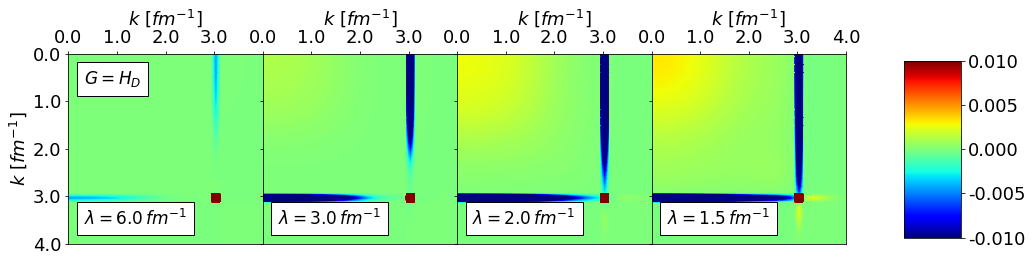

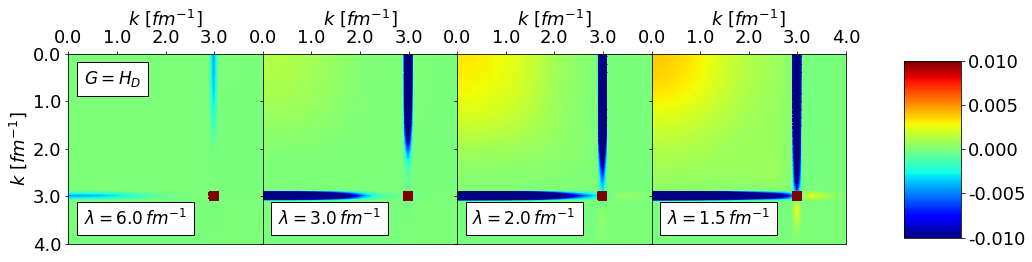

In [11]:
# Plot SRG-evolved momentum projection operators

# Project to q = 3 fm^-1
q = 3.0

# AV18
# Wegner
#momentum_projection_contours(q, 6, channel, 30.0, 4.0, ntot, 'Wegner')

# EM N3LO non-local potential
# Wegner
momentum_projection_contours(q, 10, channel, 30.0, 4.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#momentum_projection_contours(q, 10, channel, 30.0, 4.0, ntot, 'Block-diag', lambda_bd=2.00)
# Block-diagonal at 3 fm^-1
#momentum_projection_contours(q, 10, channel, 30.0, 4.0, ntot, 'Block-diag', lambda_bd=3.00)
# Wegner again but at q = 0.3 fm^-1
#momentum_projection_contours(0.3, 10, channel, 30.0, 4.0, ntot, 'Wegner')
# Wegner again but at k_max = 8 and k_mid = 2 fm^-1
momentum_projection_contours(q, 10, channel, 8.0, 2.0, ntot, 'Wegner')

# RKE N3LO semi-local potential at cutoff of 400 MeV
# Wegner
#momentum_projection_contours(q, 105, channel, 8.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#momentum_projection_contours(q, 105, channel, 8.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)

# RKE N3LO semi-local potential at cutoff of 450 MeV
# Wegner
#momentum_projection_contours(q, 106, channel, 8.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#momentum_projection_contours(q, 106, channel, 8.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)

# RKE N3LO semi-local potential at cutoff of 500 MeV
# Wegner
#momentum_projection_contours(q, 107, channel, 8.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#momentum_projection_contours(q, 107, channel, 8.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)

# RKE N4LO semi-local potential at cutoff of 450 MeV
# Wegner
#momentum_projection_contours(q, 111, channel, 8.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#momentum_projection_contours(q, 111, channel, 8.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)

# RKE N4LO semi-local potential at cutoff of 500 MeV
# Wegner
#momentum_projection_contours(q, 112, channel, 8.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#momentum_projection_contours(q, 112, channel, 8.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)

# Gezerlis et al N2LO local at cutoff 1.0 fm
# Wegner
#momentum_projection_contours(q, 222, channel, 10.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#momentum_projection_contours(q, 222, channel, 10.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)
# Block-diagonal at 3 fm^-1
#momentum_projection_contours(q, 222, channel, 10.0, 2.0, ntot, 'Block-diag', lambda_bd=3.00)

# Gezerlis et al N2LO local at cutoff 1.2 fm
# Wegner
#momentum_projection_contours(q, 224, channel, 10.0, 2.0, ntot, 'Wegner')
# Block-diagonal at 2 fm^-1
#momentum_projection_contours(q, 224, channel, 10.0, 2.0, ntot, 'Block-diag', lambda_bd=2.00)

In [12]:
# Plot momentum projection integrands

# Project to q = 3 fm^-1
#q = 0.3
q = 3.0

# EM N3LO non-local potential
# Wegner
#momentum_projection_integrand(q, 10, channel, 30.0, 4.0, ntot, 'Wegner')
# Wegner again but at k_max = 8 and k_mid = 2 fm^-1
#momentum_projection_integrand(q, 10, channel, 8.0, 2.0, ntot, 'Wegner')

In [13]:
# Plot SRG-evolved  r^2 operators

# EM N3LO non-local potential
# Wegner
#r2_contours(10, channel, 30.0, 4.0, ntot, 'Wegner')